In [44]:
"""
Part 4
"""
import math
import numpy as np
import matplotlib.pyplot as plt

data = np.load('p4_data/mds-population.npz')
print(data['D'].shape)
print(data['population_list'].shape)

(42, 42)
(42,)


In [45]:
"""
Part 4.A.I and 4.A.II
"""
from scipy.spatial import distance
from sklearn.manifold import MDS

def MDS_data(data, dimensions):
    embedding = MDS(n_components=dimensions)
    return embedding.fit_transform(data)

def recreate_D(transformed_data):
    dim = transformed_data.shape[0]
    r_D = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            r_D[i][j] = distance.euclidean(transformed_data[i],transformed_data[j])

    return r_D

def compare_Ds(D1, D2):
    dif = 0

C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


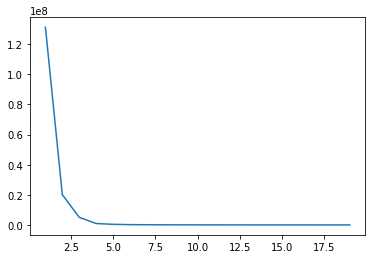

In [50]:
"""
Part 4.A.I and 4.A.II
"""
from sklearn.manifold import MDS

def MDS_data(data, dimensions):
    embedding = MDS(n_components=dimensions)
    return embedding.fit_transform(data), embedding.stress_

#recreate D, compare to original to get difference
D_difs = []
for i in range(1,20):
    data_transformed, stress = MDS_data(data['D'], i)
    D_difs.append(stress)

xvals = [i for i in range(1, 20)]
plt.plot(xvals, D_difs)

C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


<Figure size 432x288 with 0 Axes>

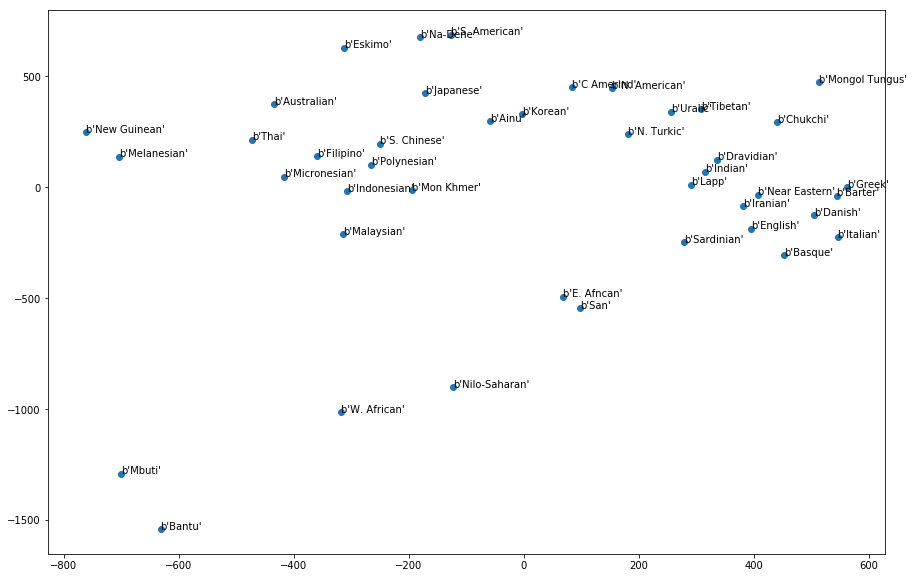

In [61]:
"""
Part 4.A.III
"""
plt.clf()
transformed_data,_ = MDS_data(data['D'], 2)
xs = [x for x,_ in transformed_data]
ys = [y for _,y in transformed_data]
labels = data['population_list']
plt.figure(figsize=(15,10))
plt.scatter(xs,ys)
for i in range(len(labels)):
    plt.annotate(labels[i], (xs[i], ys[i]))

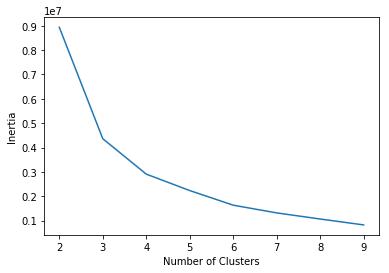

In [65]:
"""
Part 4.B
"""
from sklearn.cluster import KMeans

xvals = []
yvals = []
kmeans_arr = []
for k in range(2,10):
    xvals.append(k)
    kmeans = KMeans(n_clusters=k).fit(transformed_data)
    kmeans_arr.append(kmeans)
    yvals.append(kmeans.inertia_)

plt.clf()
plt.plot(xvals, yvals)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

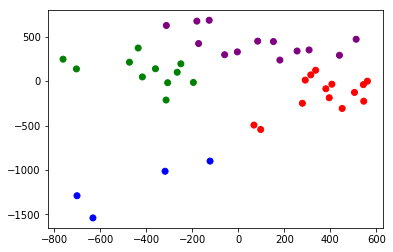

In [68]:
"""
Part 4.B
"""
km = kmeans_arr[2]
labels = km.labels_
cols = []
for l in labels:
    if l == 0:
        cols.append('r')
    elif l == 1:
        cols.append('g')
    elif l == 2:
        cols.append('b')
    else:
        cols.append('purple')
plt.clf()
plt.scatter(xs,ys, c=cols)

<Figure size 432x288 with 0 Axes>

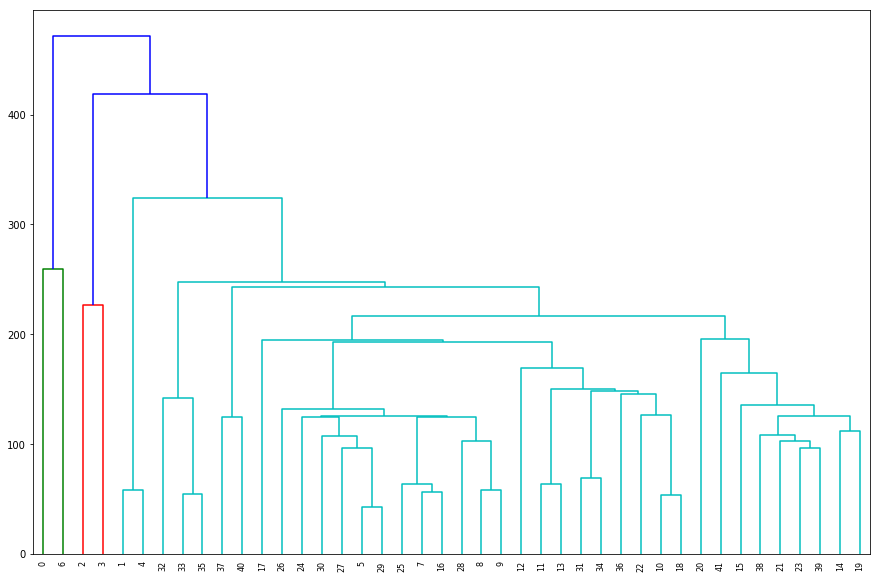

In [77]:
"""
Part 4.C
"""
from scipy.cluster import hierarchy

z = hierarchy.linkage(transformed_data)
plt.clf()
plt.figure(figsize=(15,10))
hierarchy.dendrogram(z)
plt.show()

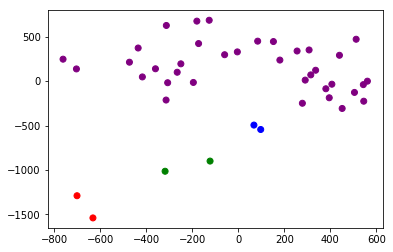

In [83]:
labels = hierarchy.fcluster(z, 300, criterion='distance')
cols = []
for l in labels:
    if l == 1:
        cols.append('r')
    elif l == 2:
        cols.append('g')
    elif l == 3:
        cols.append('b')
    else:
        cols.append('purple')
        
plt.clf()
plt.scatter(xs,ys, c=cols)

In [85]:
"""
Part 4.D
"""
import random
